In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load files from workspace results folder
results_dir = '/workspace/results/'
files = glob.glob(os.path.join(results_dir, 'final_results_*.csv'))
print(f"Found {len(files)} files")

all_data = []
for file in files:
    year = int(os.path.basename(file).split('_')[-1].split('.')[0])
    df = pd.read_csv(file)
    df['year'] = year
    all_data.append(df)

combined_df = pd.concat(all_data, ignore_index=True)

Found 21 files


In [2]:
def categorize_biome(biome):
    if biome == "Mangroves":
        return "Mangrove"
    elif biome == "N/A" or biome == "Unknown":
        return "Rock & Ice"
    elif biome == "Deserts & Xeric Shrublands":
        return "Desert"
    elif biome == "Tundra":
        return "Tundra"
    elif biome in ["Tropical & Subtropical Coniferous Forests",
                  "Tropical & Subtropical Moist Broadleaf Forests",
                  "Tropical & Subtropical Dry Broadleaf Forests"]:
        return "Tropical-Forests"
    elif biome in ["Mediterranean Forests, Woodlands & Scrub",
                  "Temperate Conifer Forests",
                  "Temperate Broadleaf & Mixed Forests"]:
        return "Temperate-Forests"
    elif biome == "Boreal Forests/Taiga":
        return "Boreal-Forests"
    elif biome in ["Tropical & Subtropical Grasslands, Savannas & Shrublands",
                  "Temperate Grasslands, Savannas & Shrublands",
                  "Montane Grasslands & Shrublands",
                  "Flooded Grasslands & Savannas"]:
        return "Grassland-Shrubland"
    else:
        return "Other"  # Changed from returning original biome
        
combined_df['biome'] = combined_df['BIOME_NAME'].apply(categorize_biome)
combined_df = combined_df[combined_df['biome'] != 'Rock & Ice']  # Filter out low sample size biomes
combined_df = combined_df[combined_df['biome'] != 'Other'] 
combined_df = combined_df[combined_df['biome'] != 'Mangrove']  
combined_df['SHARED_BOR'] = combined_df.groupby('WDPA_PID')['SHARED_BOR'].transform('first')

In [3]:
# Columns that vary by zone
zone_cols = ['hm_mean', 'hm_median', 'hm_stddev', 
             'gradient_mean', 'gradient_median', 'gradient_stddev']

# Columns that are the same across zones (keep from any zone)
static_cols = [col for col in combined_df.columns 
               if col not in zone_cols + ['zone']]

# Get static columns (use first occurrence per WDPA_PID + year)
wide_df = combined_df.groupby(['WDPA_PID', 'year']).first().reset_index()[static_cols]

# Pivot each zone metric and merge
for col in zone_cols:
    pivoted = combined_df.pivot_table(
        index=['WDPA_PID', 'year'],
        columns='zone',
        values=col,
        aggfunc='first'
    ).reset_index()
    # Rename columns: perc_water becomes perc_water_-1_1km, etc.
    pivoted.columns = ['WDPA_PID', 'year'] + [f'{col}_{zone}' for zone in pivoted.columns[2:]]
    wide_df = wide_df.merge(pivoted, on=['WDPA_PID', 'year'], how='left')

print(f"Original shape: {combined_df.shape}")
print(f"Wide shape: {wide_df.shape}")

Original shape: (520905, 45)
Wide shape: (104181, 68)


In [4]:
wide_df['edge_index_outer'] = wide_df['gradient_mean_-1_1km'] / ((wide_df['gradient_mean_1_3km'] + wide_df['gradient_mean_-1_-3km']) / 2)
wide_df['edge_index_far_outer'] = wide_df['gradient_mean_-1_1km'] / ((wide_df['gradient_mean_3_5km'] + wide_df['gradient_mean_-3_-5km']) / 2)

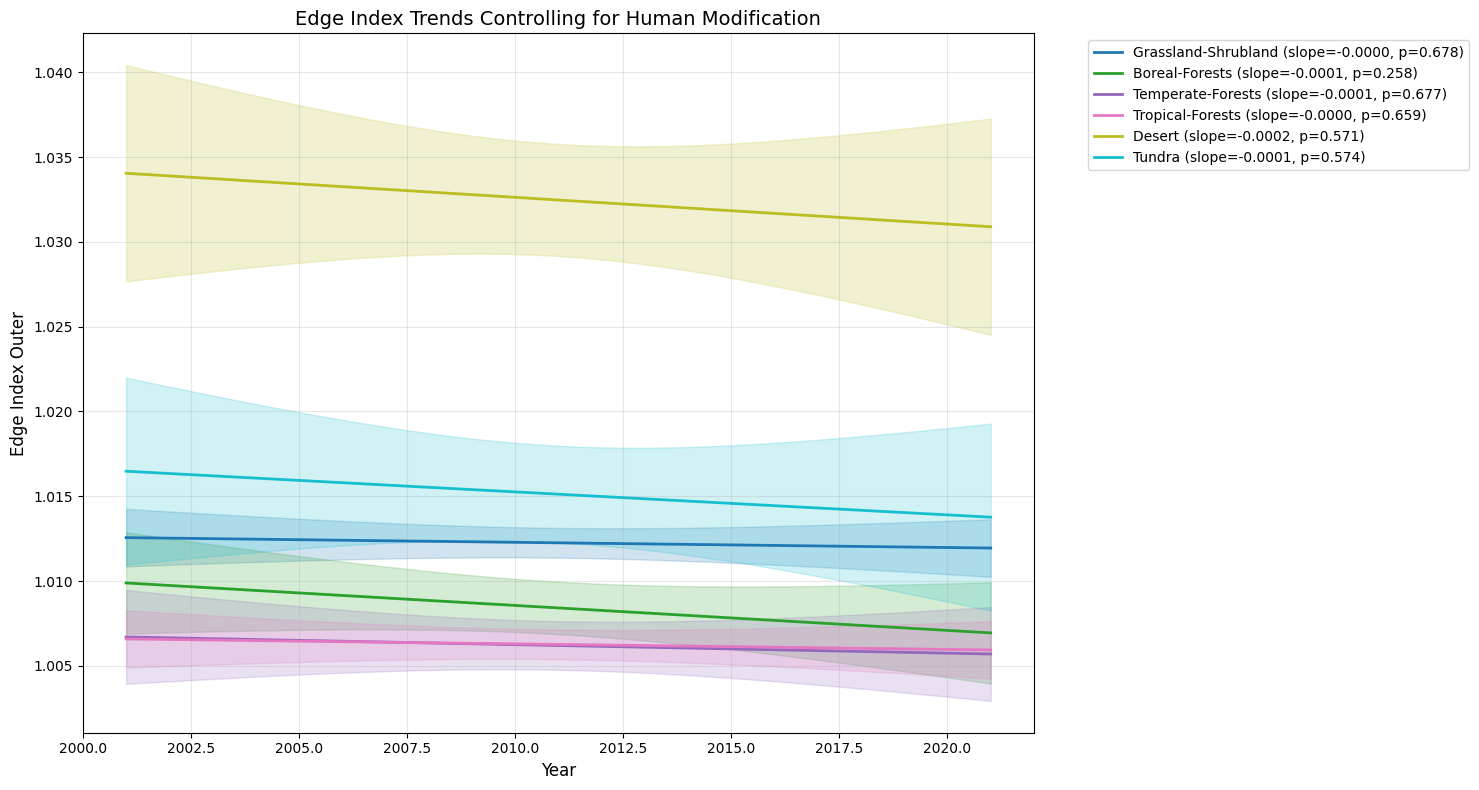

In [5]:
import statsmodels.api as sm

def plot_linear_trends_with_covariate(df, y_col, covariate_col, group_col=None, title='', ylabel='', figsize=(15, 8)):
    """
    Plot linear regression trends over time controlling for a covariate.
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    if group_col is None:
        # Overall trend with covariate
        clean_df = df[[y_col, 'year', covariate_col]].replace([np.inf, -np.inf], np.nan).dropna()
        
        # Multiple regression: y ~ year + covariate
        X = sm.add_constant(clean_df[['year', covariate_col]])
        y = clean_df[y_col].values
        model = sm.OLS(y, X).fit()
        
        # Get predictions at mean covariate value
        year_range = np.linspace(clean_df['year'].min(), clean_df['year'].max(), 100)
        covariate_mean = clean_df[covariate_col].mean()
        X_pred = pd.DataFrame({
            'const': 1,
            'year': year_range,
            covariate_col: covariate_mean
        })
        y_pred = model.predict(X_pred)
        y_pred_ci = model.get_prediction(X_pred).conf_int(alpha=0.05)
        
        # Plot
        ax.scatter(clean_df['year'], y, alpha=0.3, s=20, label='Data points')
        ax.plot(year_range, y_pred, 'r-', linewidth=2, 
               label=f'Linear fit (R²={model.rsquared:.3f}, p_year={model.pvalues["year"]:.4f})')
        ax.fill_between(year_range, y_pred_ci[:, 0], y_pred_ci[:, 1], 
                       alpha=0.2, color='red', label='95% CI')
        
        print(f"\nModel summary:")
        print(f"Year coefficient: {model.params['year']:.6f} (p={model.pvalues['year']:.4f})")
        print(f"{covariate_col} coefficient: {model.params[covariate_col]:.6f} (p={model.pvalues[covariate_col]:.4f})")
        
    else:
        # Grouped trends with covariate
        groups = df[group_col].unique()
        colors = plt.cm.tab10(np.linspace(0, 1, len(groups)))
        
        for group, color in zip(groups, colors):
            group_df = df[df[group_col] == group][[y_col, 'year', covariate_col]].replace([np.inf, -np.inf], np.nan).dropna()
            
            if len(group_df) < 5:  # Need more points for multiple regression
                continue
            
            # Multiple regression
            X = sm.add_constant(group_df[['year', covariate_col]])
            y = group_df[y_col].values
            model = sm.OLS(y, X).fit()
            
            # Predictions at mean covariate value
            year_range = np.linspace(group_df['year'].min(), group_df['year'].max(), 50)
            covariate_mean = group_df[covariate_col].mean()
            X_pred = pd.DataFrame({
                'const': 1,
                'year': year_range,
                covariate_col: covariate_mean
            })
            y_pred = model.predict(X_pred)
            y_pred_ci = model.get_prediction(X_pred).conf_int(alpha=0.05)
            
            # Plot
            ax.plot(year_range, y_pred, color=color, linewidth=2,
                   label=f'{group} (slope={model.params["year"]:.4f}, p={model.pvalues["year"]:.3f})')
            ax.fill_between(year_range, y_pred_ci[:, 0], y_pred_ci[:, 1],
                          alpha=0.2, color=color)
    
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return fig, ax

# Example usage
fig, ax = plot_linear_trends_with_covariate(
    wide_df,
    y_col='edge_index_outer',
    covariate_col='hm_mean_-1_1km',
    group_col='biome',
    title='Edge Index Trends Controlling for Human Modification',
    ylabel='Edge Index Outer'
)
plt.show()

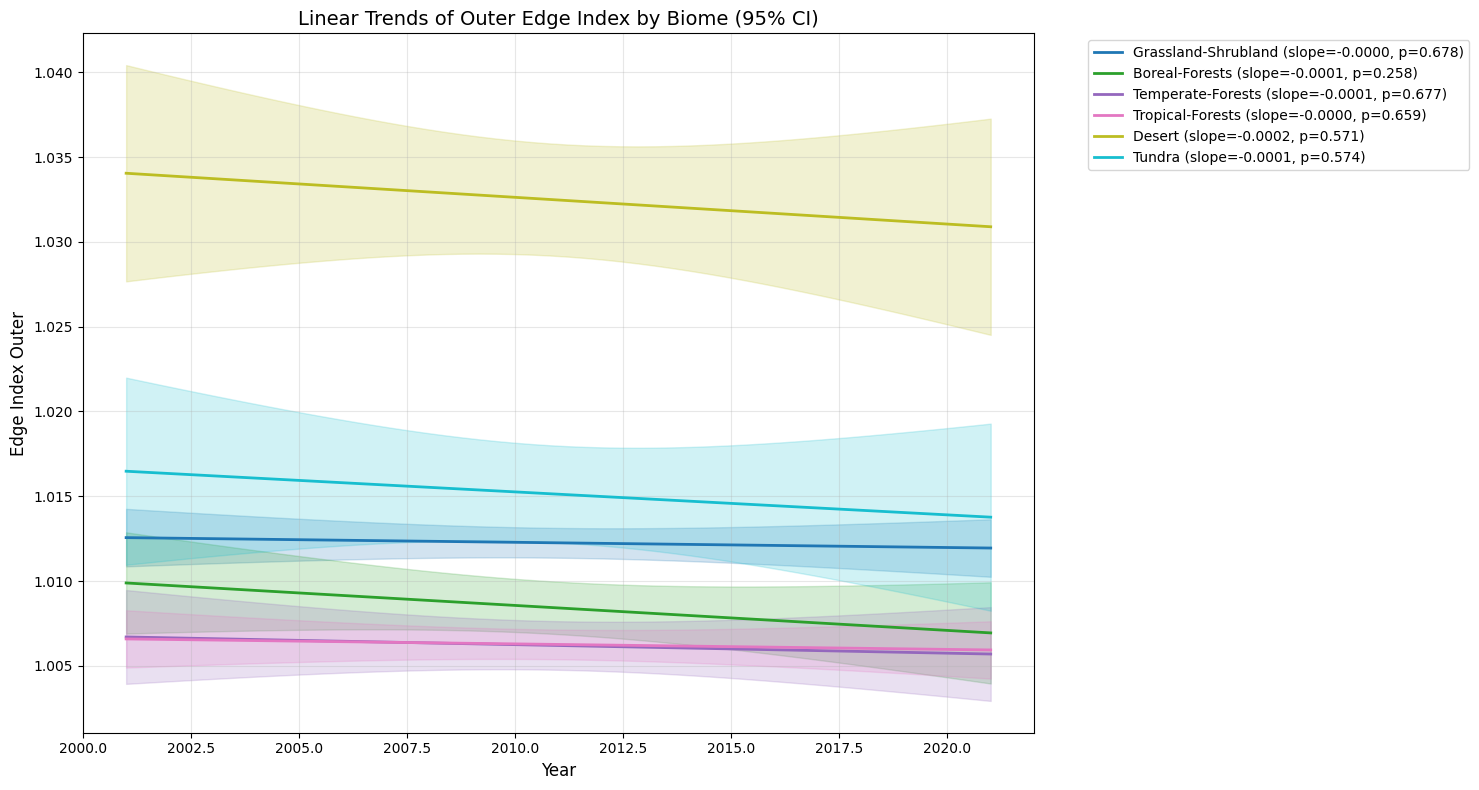

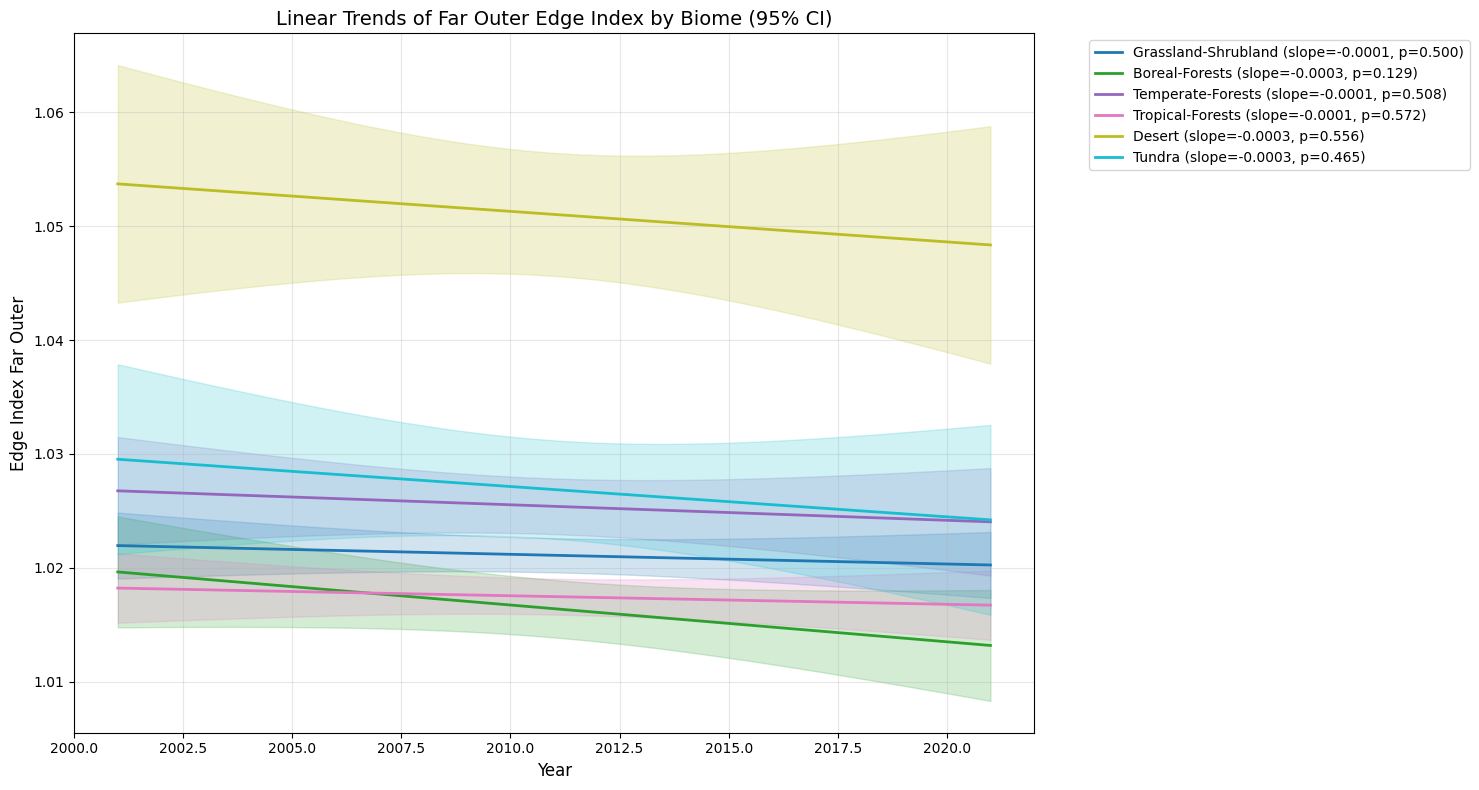


Model summary:
Year coefficient: -0.000060 (p=0.2246)
hm_mean_-1_1km coefficient: 0.006958 (p=0.0001)


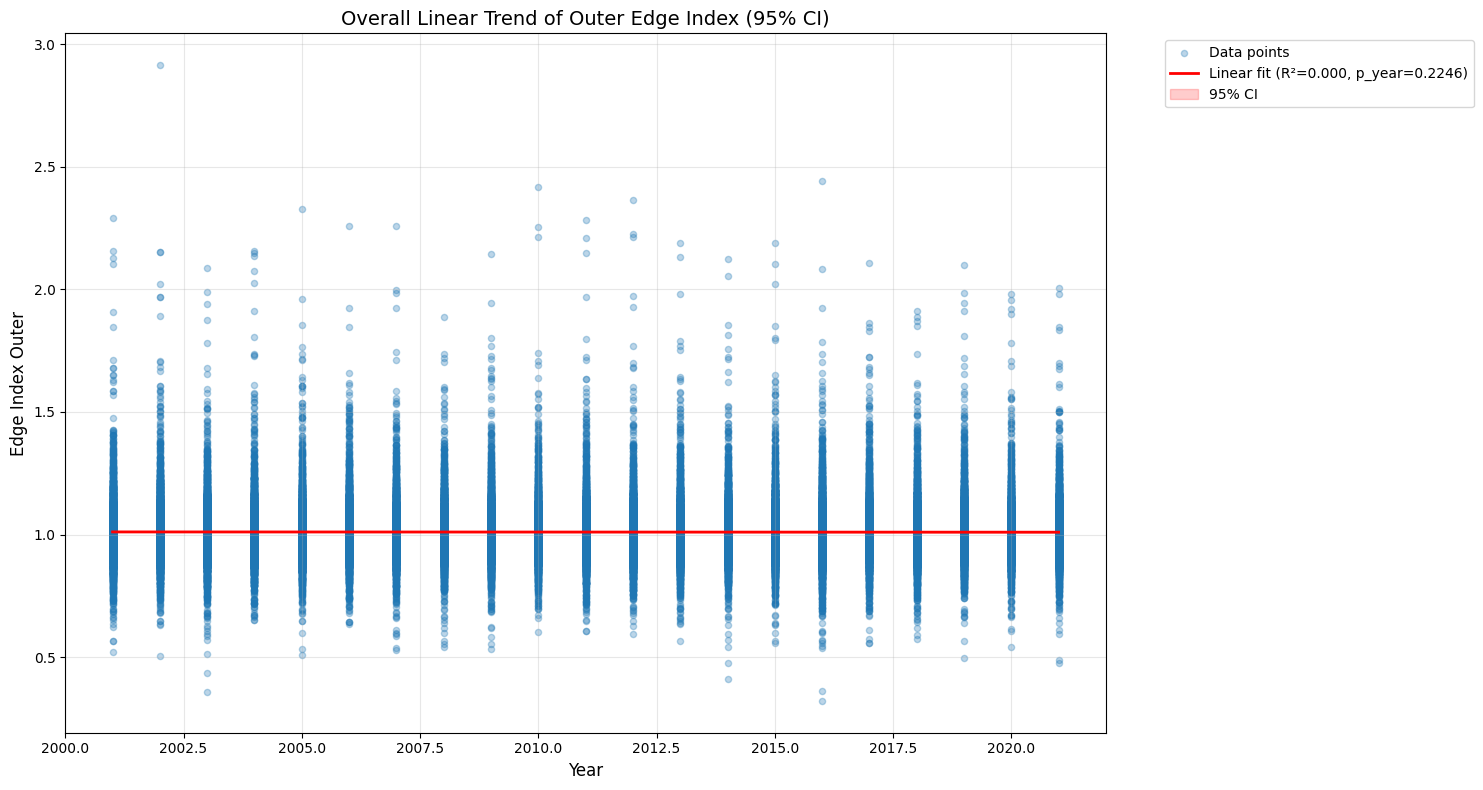


Model summary:
Year coefficient: -0.000135 (p=0.1034)
hm_mean_-1_1km coefficient: 0.020543 (p=0.0000)


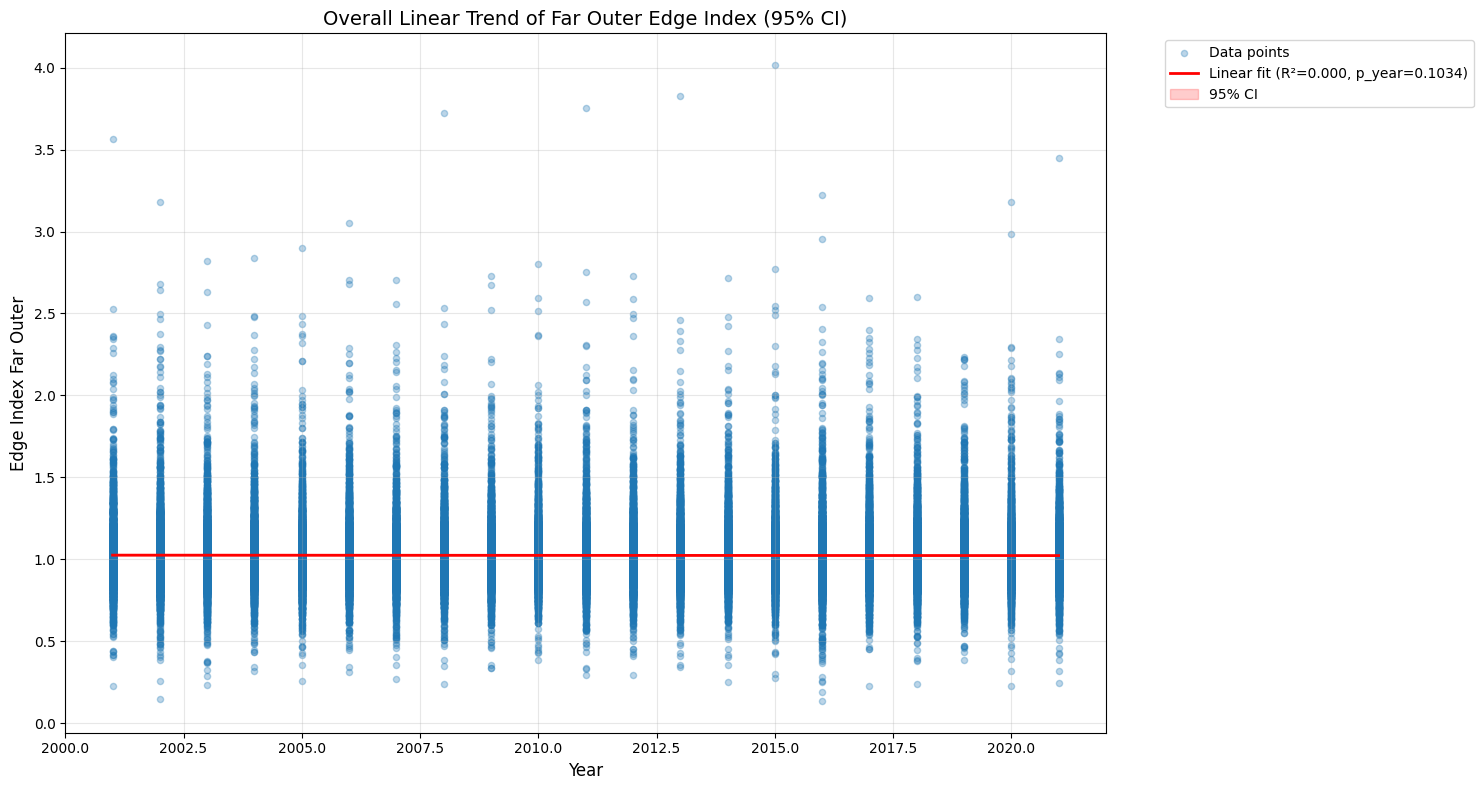

In [6]:
# Plot 1: Edge index outer by biome
fig1, ax1 = plot_linear_trends_with_covariate(
    wide_df, 
    y_col='edge_index_outer',
    covariate_col='hm_mean_-1_1km',
    group_col='biome',
    title='Linear Trends of Outer Edge Index by Biome (95% CI)',
    ylabel='Edge Index Outer'
)
plt.show()

# Plot 2: Edge index far outer by biome
fig2, ax2 = plot_linear_trends_with_covariate(
    wide_df,
    y_col='edge_index_far_outer',
    covariate_col='hm_mean_-1_1km',
    group_col='biome',
    title='Linear Trends of Far Outer Edge Index by Biome (95% CI)',
    ylabel='Edge Index Far Outer'
)
plt.show()

# Plot 3: Overall edge index outer
fig3, ax3 = plot_linear_trends_with_covariate(
    wide_df,
    y_col='edge_index_outer',
    covariate_col='hm_mean_-1_1km',
    group_col=None,
    title='Overall Linear Trend of Outer Edge Index (95% CI)',
    ylabel='Edge Index Outer'
)
plt.show()

# Plot 4: Overall edge index far outer
fig4, ax4 = plot_linear_trends_with_covariate(
    wide_df,
    y_col='edge_index_far_outer',
    covariate_col='hm_mean_-1_1km',
    group_col=None,
    title='Overall Linear Trend of Far Outer Edge Index (95% CI)',
    ylabel='Edge Index Far Outer'
)
plt.show()

In [7]:
wide_df['edge_index_outer_median'] = wide_df['gradient_median_-1_1km'] / ((wide_df['gradient_median_1_3km'] + wide_df['gradient_median_-1_-3km']) / 2)
wide_df['edge_index_far_outer_median'] = wide_df['gradient_median_-1_1km'] / ((wide_df['gradient_median_3_5km'] + wide_df['gradient_median_-3_-5km']) / 2)

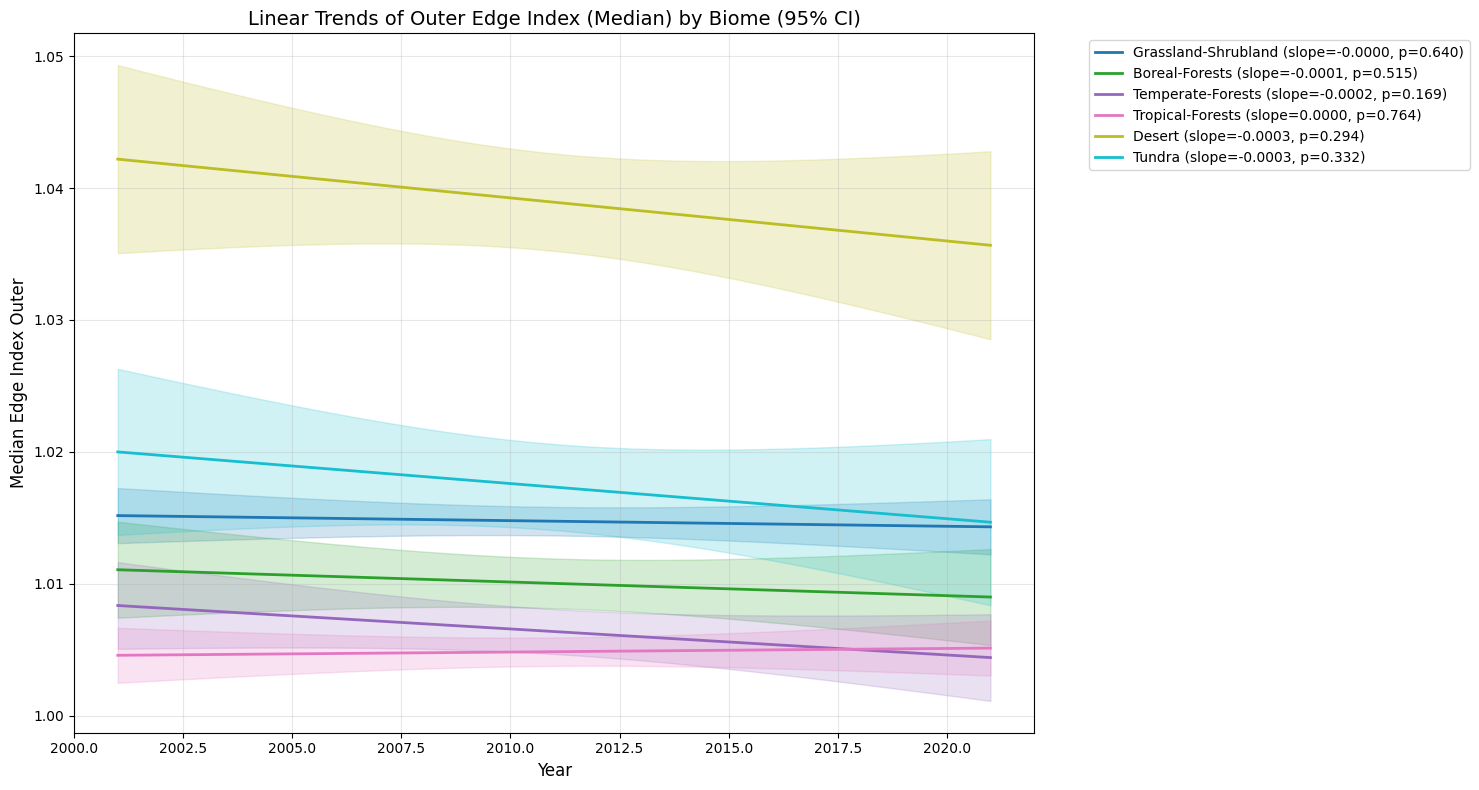

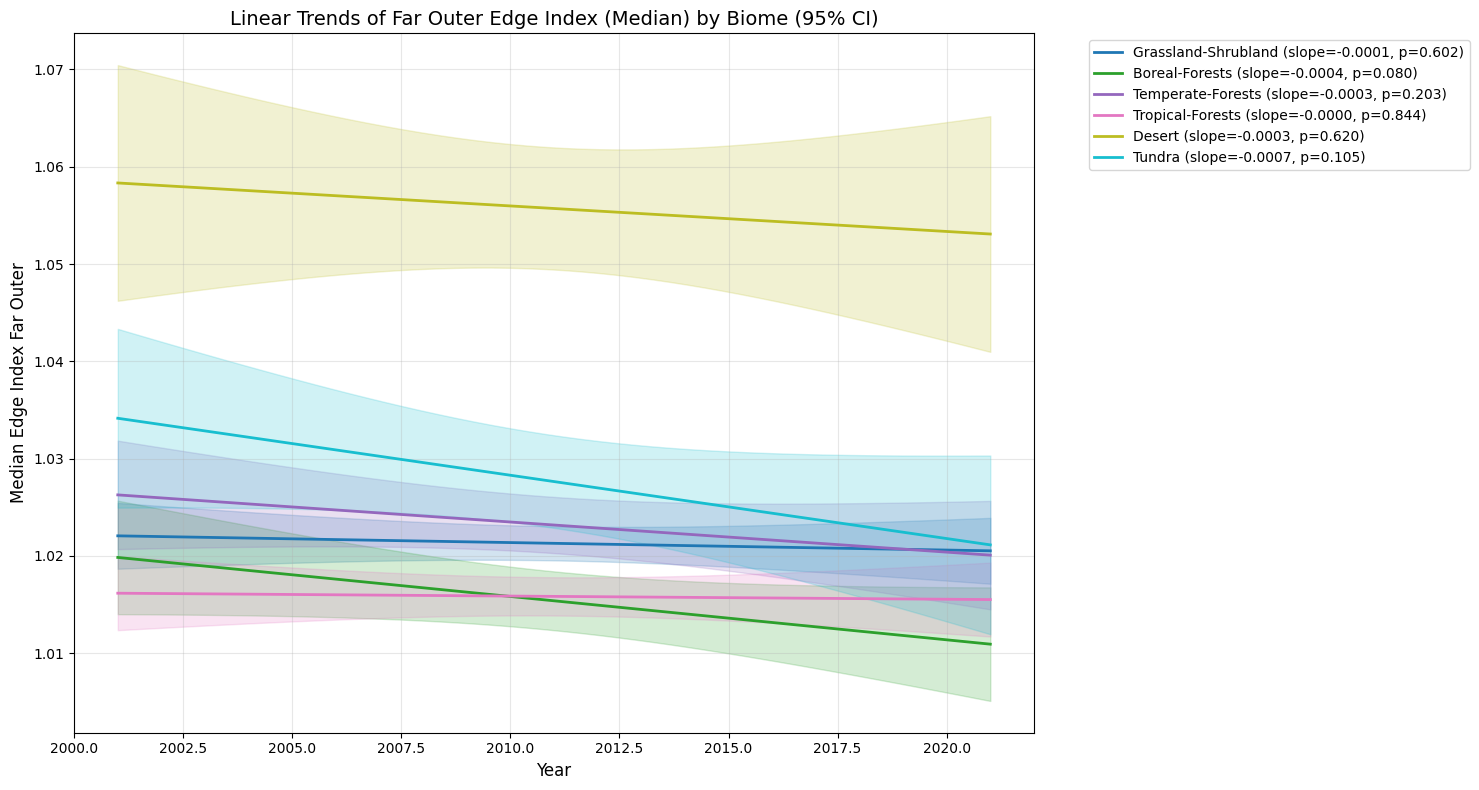


Model summary:
Year coefficient: -0.000094 (p=0.1058)
hm_median_-1_1km coefficient: 0.009271 (p=0.0000)


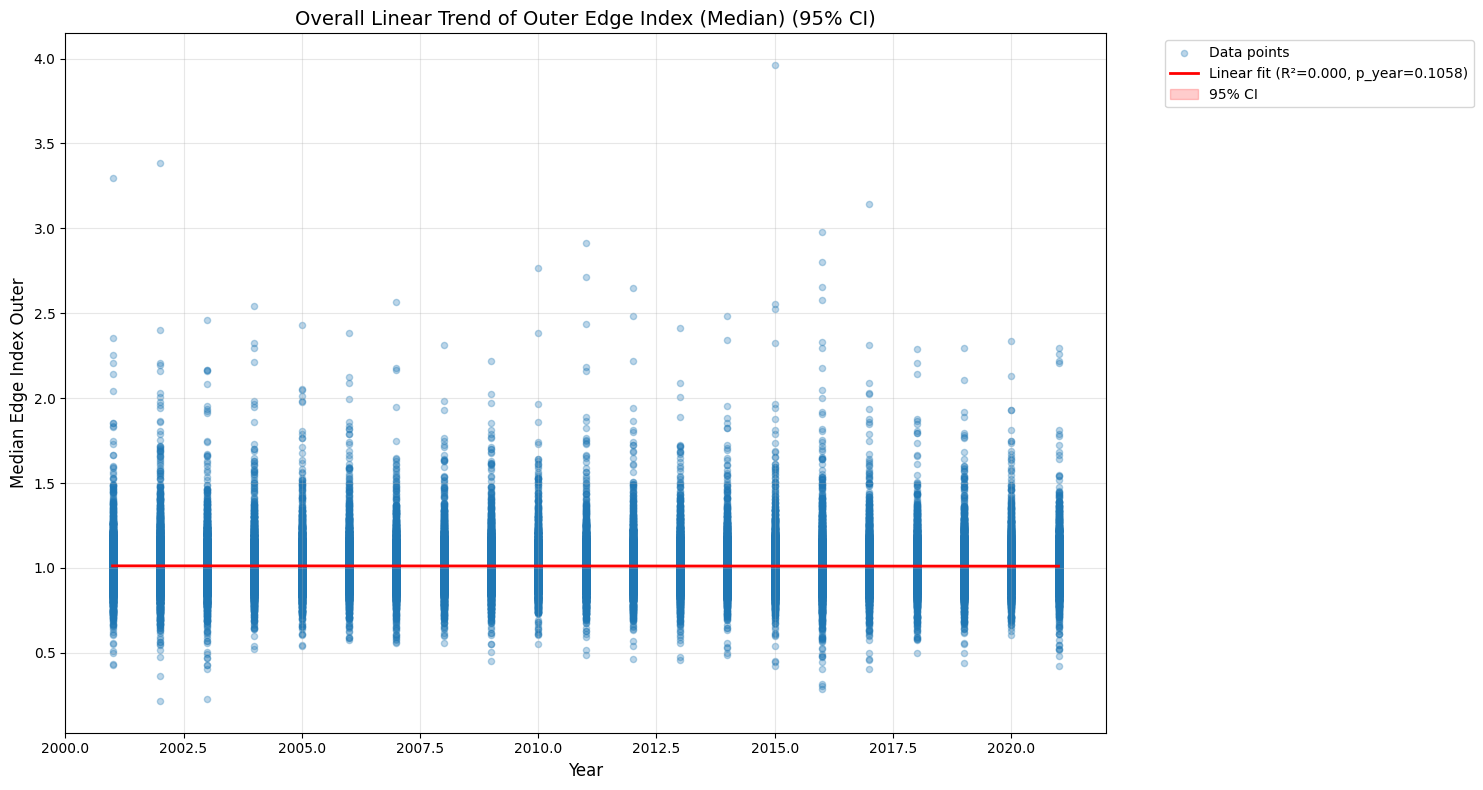


Model summary:
Year coefficient: -0.000182 (p=0.0650)
hm_median_-1_1km coefficient: 0.020146 (p=0.0000)


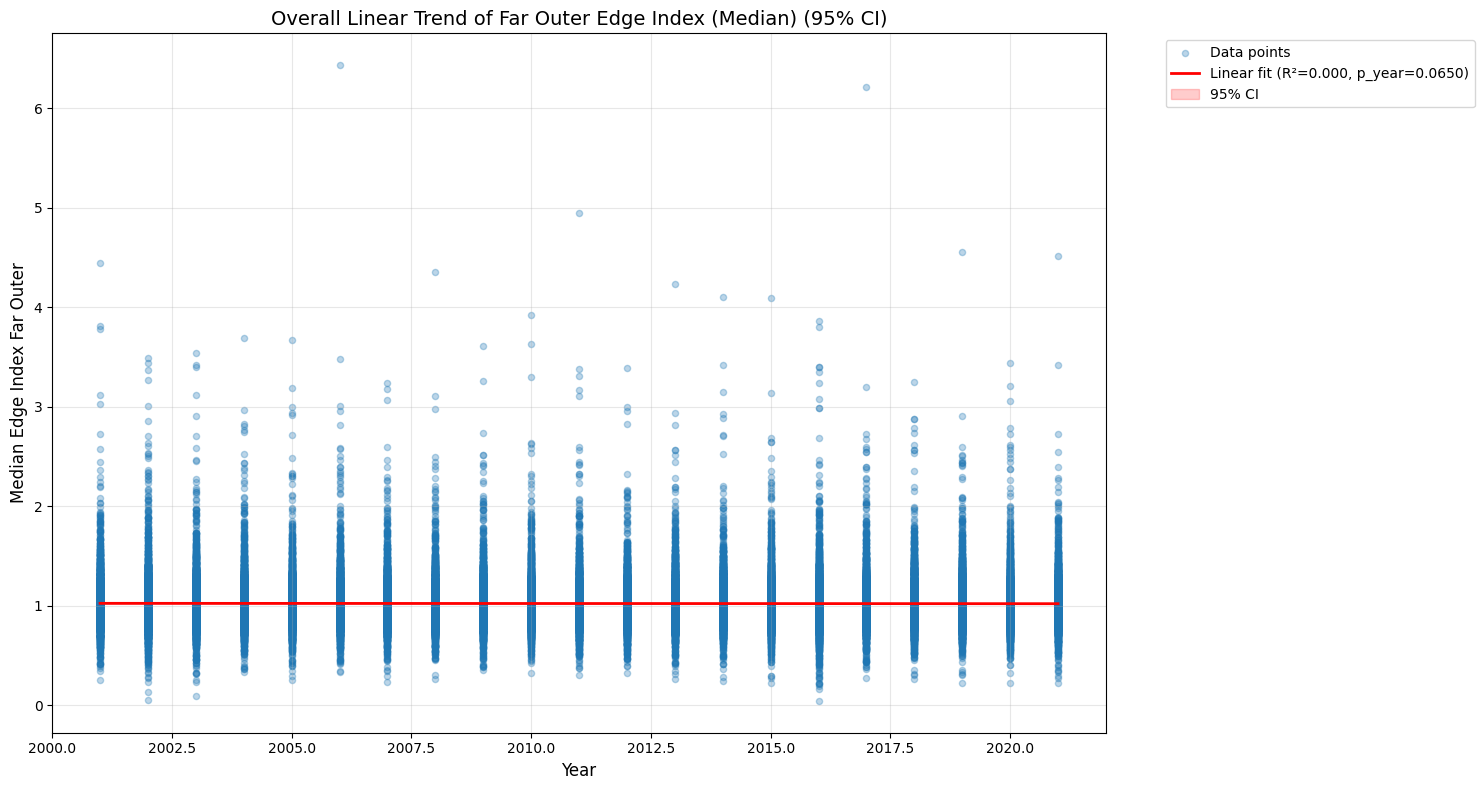

In [9]:
# Plot 1: Edge index outer median by biome
fig1, ax1 = plot_linear_trends_with_covariate(
    wide_df, 
    y_col='edge_index_outer_median',
    covariate_col='hm_median_-1_1km',
    group_col='biome',
    title='Linear Trends of Outer Edge Index (Median) by Biome (95% CI)',
    ylabel='Median Edge Index Outer'
)
plt.show()

# Plot 2: Edge index far outer median by biome
fig2, ax2 = plot_linear_trends_with_covariate(
    wide_df,
    y_col='edge_index_far_outer_median',
    covariate_col='hm_median_-1_1km',
    group_col='biome',
    title='Linear Trends of Far Outer Edge Index (Median) by Biome (95% CI)',
    ylabel='Median Edge Index Far Outer'
)
plt.show()

# Plot 3: Overall edge index outer median
fig3, ax3 = plot_linear_trends_with_covariate(
    wide_df,
    y_col='edge_index_outer_median',
    covariate_col='hm_median_-1_1km',
    group_col=None,
    title='Overall Linear Trend of Outer Edge Index (Median) (95% CI)',
    ylabel='Median Edge Index Outer'
)
plt.show()

# Plot 4: Overall edge index far outer median
fig4, ax4 = plot_linear_trends_with_covariate(
    wide_df,
    y_col='edge_index_far_outer_median',
    covariate_col='hm_median_-1_1km',
    group_col=None,
    title='Overall Linear Trend of Far Outer Edge Index (Median) (95% CI)',
    ylabel='Median Edge Index Far Outer'
)
plt.show()

In [ ]:
# Show detailed view of "Other" biomes
other_df = combined_df[combined_df['biome'] == 'Other'][['WDPA_PID', 'ORIG_NAME', 'BIOME_NAME', 'year', 'zone']].drop_duplicates()
print(f"Total 'Other' observations: {len(combined_df[combined_df['biome'] == 'Other'])}")
print(f"Unique WDPA_PIDs with 'Other': {other_df['WDPA_PID'].nunique()}")
print(f"\nSample of 'Other' biomes:")
print(other_df.head(20))

# Show unique BIOME_NAME values in "Other"
print(f"\nUnique BIOME_NAME values categorized as 'Other':")
print(other_df['BIOME_NAME'].unique())

# Count by BIOME_NAME
print(f"\nCount by BIOME_NAME in 'Other' category:")
print(other_df.groupby('BIOME_NAME')['WDPA_PID'].nunique().sort_values(ascending=False))

In [ ]:
# Check if "Other" biomes are year-specific
other_df = combined_df[combined_df['biome'] == 'Other']

print(f"Total 'Other' observations: {len(other_df)}")
print(f"Unique WDPA_PIDs with 'Other': {other_df['WDPA_PID'].nunique()}")
print(f"\nYears with 'Other' biomes:")
print(other_df['year'].value_counts().sort_index())

# Check if these PAs have "Other" across all years or just some
print(f"\nDo these PAs have 'Other' in all years?")
other_pids = other_df['WDPA_PID'].unique()
for pid in other_pids[:5]:  # Check first 5
    pa_years = other_df[other_df['WDPA_PID'] == pid]['year'].unique()
    print(f"WDPA_PID {pid}: {len(pa_years)} years - {sorted(pa_years)}")

# Show what BIOME_NAME values are in "Other"
print(f"\nUnique BIOME_NAME values in 'Other':")
print(other_df['BIOME_NAME'].unique())

# Count by PA
print(f"\nProtected areas with 'Other' biome:")
print(other_df.groupby('WDPA_PID')['ORIG_NAME'].first().head(10))

In [ ]:
# Count WDPA_PIDs per biome category
biome_counts = combined_df.groupby('biome')['WDPA_PID'].nunique().sort_values(ascending=False)
print("Number of unique WDPA_PIDs per biome category:")
print(biome_counts)
print(f"\nTotal unique WDPA_PIDs: {combined_df['WDPA_PID'].nunique()}")

# Check in wide_df (after filtering Rock & Ice)
wide_biome_counts = wide_df.groupby('biome')['WDPA_PID'].nunique().sort_values(ascending=False)
print("\n\nIn wide_df (after Rock & Ice filter):")
print(wide_biome_counts)
print(f"\nTotal unique WDPA_PIDs in wide_df: {wide_df['WDPA_PID'].nunique()}")

# Check percentage
print("\n\nPercentage of PAs per biome:")
for biome, count in biome_counts.items():
    pct = (count / combined_df['WDPA_PID'].nunique()) * 100
    print(f"{biome}: {count} PAs ({pct:.1f}%)")